<a href="https://colab.research.google.com/github/gustavoteixeirah/dataset-celulas-malaria/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Define folder paths
# FOLDER = "/content/drive/MyDrive/dataset.celulas"
FOLDER = "dataset.celulas"
PARASITIZED_FOLDER = os.path.join(FOLDER, "Parasitized/")
UNINFECTED_FOLDER = os.path.join(FOLDER, "Uninfected/")



In [2]:
from skimage.io import imread  # Assuming you have scikit-image installed
from skimage.transform import resize  # Correct import for the resize function
import time

target_size = (128, 128)

# Function to load and preprocess images with progress counter
def load_and_preprocess_image(folder_path, image_name, start_time):
    image_path = os.path.join(folder_path, image_name)
    image = imread(image_path, as_gray=True)  # Read as grayscale
    image = resize(image, target_size)  # Resize to target dimensions
    # You can add further preprocessing steps here (e.g., normalization)

    # Print progress every 1000 images
    if (len(parasitized_images) + len(uninfected_images)) % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {len(parasitized_images) + len(uninfected_images)} images in {elapsed_time:.2f} seconds.")

    return image


# Load image data
parasitized_images = []
uninfected_images = []
start_time = time.time()  # Start time for progress tracking
print(f"{start_time:.2f} seconds.")

# Limit to loading only 2000 images each
image_count = 0
limit = 6000

for image_name in os.listdir(PARASITIZED_FOLDER):
    if (image_name.split('.')[1] == 'png') and image_count < limit:
        parasitized_images.append(load_and_preprocess_image(PARASITIZED_FOLDER, image_name, start_time))
        image_count += 1

image_count = 0

for image_name in os.listdir(UNINFECTED_FOLDER):
    if (image_name.split('.')[1] == 'png') and image_count < limit:
        uninfected_images.append(load_and_preprocess_image(UNINFECTED_FOLDER, image_name, start_time))
        image_count += 1

# Print final message after processing all images
elapsed_time = time.time() - start_time
print(f"Finished processing all images in {elapsed_time:.2f} seconds.")

1724387382.99 seconds.
Processed 0 images in 0.10 seconds.
Processed 1000 images in 1.43 seconds.
Processed 2000 images in 2.66 seconds.
Processed 3000 images in 3.88 seconds.
Processed 4000 images in 5.25 seconds.
Processed 5000 images in 6.58 seconds.
Processed 6000 images in 7.94 seconds.
Processed 7000 images in 9.17 seconds.
Processed 8000 images in 10.41 seconds.
Processed 9000 images in 11.64 seconds.
Processed 10000 images in 12.87 seconds.
Processed 11000 images in 14.10 seconds.
Finished processing all images in 15.34 seconds.


In [3]:
print(f"Shape of first parasitized image: {parasitized_images[0].shape}")
print(f"Shape of first uninfected image: {uninfected_images[0].shape}")

Shape of first parasitized image: (128, 128)
Shape of first uninfected image: (128, 128)


In [4]:
import numpy as np

# Check initial shapes and sizes
print(f"Parasitized images shape: {np.array(parasitized_images).shape}")
print(f"Uninfected images shape: {np.array(uninfected_images).shape}")

# Incremental concatenation
def incremental_concatenate(arrays, batch_size=100):
    result = []
    for i in range(0, len(arrays), batch_size):
        batch = arrays[i:i + batch_size]
        result.append(np.array(batch))

        print(f"Returning from: {i}")
    return np.concatenate(result)


# Incrementally concatenate images
parasitized_images_array = incremental_concatenate(parasitized_images)
uninfected_images_array = incremental_concatenate(uninfected_images)

X = np.concatenate((parasitized_images_array, uninfected_images_array))
y = np.array([1] * len(parasitized_images_array) + [0] * len(uninfected_images_array))

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Parasitized images shape: (6000, 128, 128)
Uninfected images shape: (6000, 128, 128)
Returning from: 0
Returning from: 100
Returning from: 200
Returning from: 300
Returning from: 400
Returning from: 500
Returning from: 600
Returning from: 700
Returning from: 800
Returning from: 900
Returning from: 1000
Returning from: 1100
Returning from: 1200
Returning from: 1300
Returning from: 1400
Returning from: 1500
Returning from: 1600
Returning from: 1700
Returning from: 1800
Returning from: 1900
Returning from: 2000
Returning from: 2100
Returning from: 2200
Returning from: 2300
Returning from: 2400
Returning from: 2500
Returning from: 2600
Returning from: 2700
Returning from: 2800
Returning from: 2900
Returning from: 3000
Returning from: 3100
Returning from: 3200
Returning from: 3300
Returning from: 3400
Returning from: 3500
Returning from: 3600
Returning from: 3700
Returning from: 3800
Returning from: 3900
Returning from: 4000
Returning from: 4100
Returning from: 4200
Returning from: 4300
Ret

In [5]:
# Split data into training and testing sets (consider using scikit-learn's train_test_split)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (9600, 128, 128)
Shape of y_train: (9600,)


In [6]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [7]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

print(X_train_flat.shape)
print(X_test_flat.shape)

(9600, 16384)
(2400, 16384)


In [8]:
from sklearn.ensemble import RandomForestClassifier

# Treinamento de um modelo Random Forest
def train(X_train, y_train, n_estimators=100):
  model = RandomForestClassifier(n_estimators=n_estimators)
  model.fit(X_train, y_train.flatten())
  return model

model = train(X_train_flat, y_train)

Resultados de Teste
Acurácia: 0.7979166666666667
F1 score: 0.7975888305198741


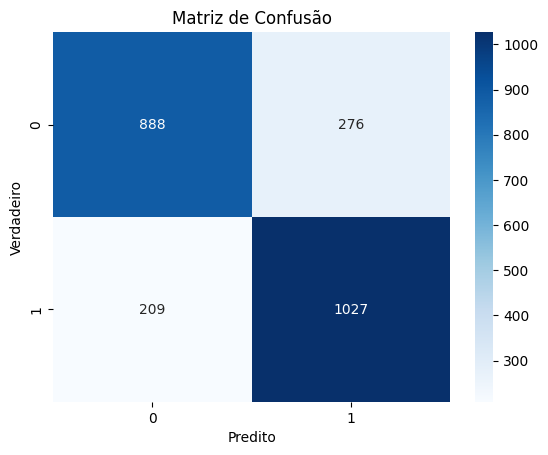

Resultados de Treino
Acurácia: 1.0
F1 score: 1.0


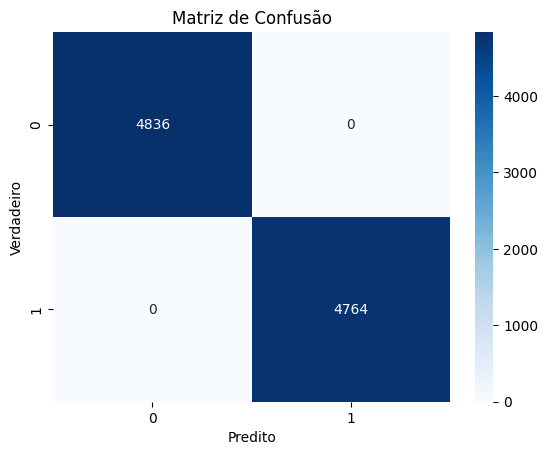

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix

# Inferência e avaliação
def predict_and_evaluate(model, X_test, y_test, normalize=None):

  # Inferência
  y_pred = model.predict(X_test)

  # Métricas
  print('Acurácia:', accuracy_score(y_test, y_pred))
  print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

  # Matriz de confusão
  conf_matrix = confusion_matrix(y_test, y_pred, normalize=normalize)

  fmt = '.2f' if normalize == 'true' else 'd'
  sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title('Matriz de Confusão')
  plt.xlabel('Predito')
  plt.ylabel('Verdadeiro')
  plt.show()

print('Resultados de Teste')
predict_and_evaluate(model, X_test_flat, y_test)
print('Resultados de Treino')
predict_and_evaluate(model, X_train_flat, y_train)

In [11]:
from sklearn.cluster import KMeans


# Treinamento de um modelo Random Forest
def trainKMeans(X_train, y_train, n_clusters=5):
  model = KMeans(n_clusters=n_clusters)
  model.fit(X_train, y_train.flatten())
  return model

model = trainKMeans(X_train_flat, y_train)

Resultados de Teste
Acurácia: 0.13208333333333333
F1 score: 0.21158045841640397


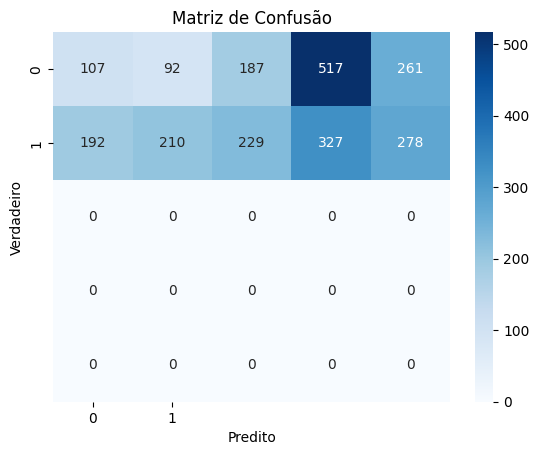

Resultados de Treino
Acurácia: 0.13260416666666666
F1 score: 0.2131591665256866


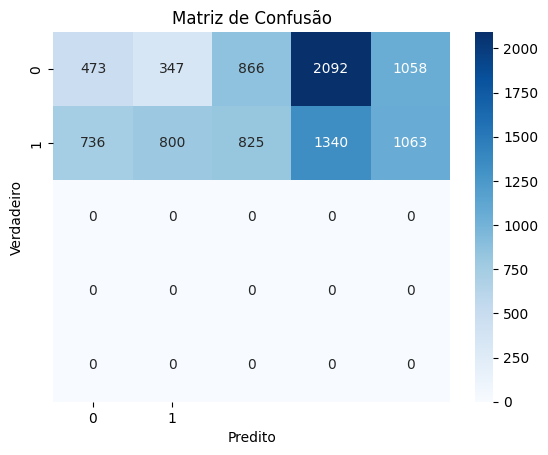

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix

# Inferência e avaliação
def predict_and_evaluate(model, X_test, y_test, normalize=None):

  # Inferência
  y_pred = model.predict(X_test)

  # Métricas
  print('Acurácia:', accuracy_score(y_test, y_pred))
  print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

  # Matriz de confusão
  conf_matrix = confusion_matrix(y_test, y_pred, normalize=normalize)

  fmt = '.2f' if normalize == 'true' else 'd'
  sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title('Matriz de Confusão')
  plt.xlabel('Predito')
  plt.ylabel('Verdadeiro')
  plt.show()

print('Resultados de Teste')
predict_and_evaluate(model, X_test_flat, y_test)
print('Resultados de Treino')
predict_and_evaluate(model, X_train_flat, y_train)

